In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Neuron ... n
# Input ... x
# Weight ... w ... hold by a synapse. The snyaptic strength for the input
# A synapse interacts with the input to the Neuron multiplicatively
# Flow ... F ... So what flows to the neuron is w * x
# There are multiple inputs
# Bias ... b ... trigger happiness
# Activiation Function ... f ... tanh or sigmoid. Also called squashing functions because it smoothly caps it out to -1 or +1.
# Out ... o ... What comes out of the neuron when the Activiation Function is applied to the sum of the Flows multiplied by the Bias.

In [3]:
from graphviz import Digraph

def trace(rootValue):
    nodes, edges = set(), set()
    def build(value):
        if value not in nodes:
            nodes.add(value)
            for term in value._terms:
                edges.add((term, value))
                build(term)
    build(rootValue)
    return nodes, edges

def draw_dot(rootValue, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(rootValue)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n._label, n.data, n.grad), shape='record')
        if n._op != 'prim':
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [4]:
class Value:
    """ 
        stores a single scalar value and its gradient
        Implemented backward propagation
        Implemented programmatic backward propagation
        Fix non-accumulation of grad bug
    """
    def __init__(self, data: float, _terms=(), _op='prim', _label="?"):
        """ 
        data: a float or integer
        _terms: terms this value combines, starting with self
        _op: operation by how the terms are combined
        _label: label for self
        """
        self.data = data
        self.grad = 0 # by default 0, means initially no effect, does not effect the output. 
                      # So changing the variable does not effect the Loss function
        # internal variables used for micrograd graph construction
        #
        # the function that is doing the chain rule. How to store the output gradient 
        # into the input gradient. Propagtes the gradient
        self._backward = lambda: None; # lambda: None is the empty function, for leaf nodes.
        self._terms = set(_terms)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc
        self._label = _label

    def __add__(self, other):
        # In case other is a number, wrap it as a Value
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            # In the case of a + a, self and other are the same
            # instance. In that case other.grad overrides self.grad 
            # instead of accumulating. Also, if self.grad is used more 
            # than once, self.grad needs to accumlate it's former grads 
            # to itself. Hence instead of xyz.grad = 1.0 * out.grad, do
            # xyz.grad += 1.0 * out.grad
            #
            # self.grad = ???
            # the local derivative of an addition is always 1.0
            # the global derivative is the local derivative times the 
            # already? backpropagated out grad
            self.grad += 1.0 * out.grad
            # other.grad = ???
            # the local derivative of an addition is always 1.0
            # the global derivative is the local derivative times the 
            # already? backpropagated out grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other): # arguments already reversed
        return self + other

    def __mul__(self, other):
        # In case other is a number, wrap it as a Value
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            # In the case of a * a, self and other are the same
            # instance. In that case other.grad overrides self.grad 
            # instead of accumulating. Also, if self.grad is used more 
            # than once, self.grad needs to accumlate it's former grads 
            # to itself. Hence instead of xyz.grad = 1.0 * out.grad, do
            # xyz.grad += 1.0 * out.grad
            # self.grad = ???
            # the local derivative of a multiplication is the data of the other multiplicant
            # the global derivative is the local derivative times the 
            # already? backpropagated out grad
            self.grad += other.data * out.grad
            # other.grad = ???
            # the local derivative of a multiplication is the data of the other multiplicant
            # the global derivative is the local derivative times the 
            # already? backpropagated out grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    """
    https://blog.finxter.com/python-__rmul__-magic-method/
    The Python __rmul__() method implements the reverse multiplication operation that is multiplication with reflected, 
    swapped operands. So, when you call x * y, Python attempts to call x.__mul__(y). Only if the method is not implemented 
    on the left operand, Python attempts to call __rmul__ on the right operand and if this isn’t implemented either, it 
    raises a TypeError. 
    So, the difference between x.__mul__(y) and x.__rmul__(y) is that the former calculates x * y whereas 
    the latter calculates y * x — both calling the respective method defined on the object x.
    """
    def __rmul__(self, other): # arguments already reversed
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"        
        # In case other is a number, wrap it as a Value
        # other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            # self.grad = https://d138zd1ktt9iqe.cloudfront.net/media/seo_landing_files/differentiation-rules-1626970087.png
            # The derivative of a power function is 
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        # Implement division as a * (b**-1) t.i. the Negative Exponent Rule
        out = self * other**-1
        out._op = '*(/)'
        return out

    def __rtruediv__(self, other): # arguments already reversed
        # Implement division as a * (b**-1) t.i. the Negative Exponent Rule
        out = other * self**-1
        out._op = '*(/)'
        return out

    def __neg__(self):
        # Implement negation as multiplication by -1
        return self * -1

    def __sub__(self, other):
        # Implement subtraction as addition with negation of the other term
        out =  self + (-other)
        out._op = '+(-)'
        return out

    def __rsub__(self, other): # arguments already reversed
        return other + (-self)
        
    def tanh(self):
        x = self.data
        # See https://en.wikipedia.org/wiki/Hyperbolic_functions#Exponential_definitions
        # Hyperbolic tangent
        t = (math.exp(2 * x) - 1)/(math.exp(2 * x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            # self.grad = ???
            # the local derivative of a tanh is https://en.wikipedia.org/wiki/Hyperbolic_functions#Derivatives times the 
            # already? backpropagated out grad
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            # d/dx of e**x is e**x t.i. math.exp(x)
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        # topological order all of the terms in the graph
        topo = []
        visited = set()
        def build_topo(v):
            # case when a term is used more than once in teh graph
            if v not in visited:
                visited.add(v)
                for term in v._terms:
                    build_topo(term)
                topo.append(v)
        build_topo(self)
        # set top term to the base grad of 1.0
        self.grad = 1
        # go one term backward at a time and apply the chain rule to get its gradient
        for v in reversed(topo):
            v._backward()
        
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad}, op={self._op}, label={self._label})"

In [5]:
def lol1():
    a = Value(2.0)
    # In case other is a number, wrap it as a Value
    return a * 2

print(lol1())

Value(data=4.0, grad=0, op=*, label=?)


In [6]:
def lol2():
    a = Value(2.0)
    # In case self is a number t.i. 2.__mul__(a), __rmul__ is , gives a.__mul__(2)
    return 2 * a

print(lol2())

Value(data=4.0, grad=0, op=*, label=?)


In [7]:
def lol3():
    a = Value(2.0)
    b = Value(4.0)
    # Implement division as a * (b**-1) t.i. the Negative Exponent Rule
    # Here, the base number is 4 and the exponent is -1. Hence, the value of (1/4)**1 which is 1/4.
    return a / b

print(lol3())

Value(data=0.5, grad=0, op=*(/), label=?)


In [8]:
def lol4():
    a = Value(2.0)
    b = Value(4.0)
    # Implement subtraction as addition of the negated other term
    return a - b

print(lol4())

Value(data=-2.0, grad=0, op=+(-), label=?)


In [9]:
def lol5():
    # In case self is a number, reverse arguments (__radd__) and hence wrap then-other as a Value
    a = 1
    b = Value(4.0)
    return a + b

print(lol5())

Value(data=5.0, grad=0, op=+, label=?)


In [10]:
def lol6():
    # In case self is a number, reverse arguments (__rsub__) and hence wrap then-other as a Value
    a = 1
    b = Value(4.0)
    return a - b

print(lol6())

Value(data=-3.0, grad=0, op=+, label=?)


In [11]:
def lol7():
    # In case self is a number, reverse arguments (__rdiv__) and hence wrap then-other as a Value
    a = 1
    b = Value(4.0)
    return 1 / b

print(lol7())

Value(data=0.25, grad=0, op=*(/), label=?)


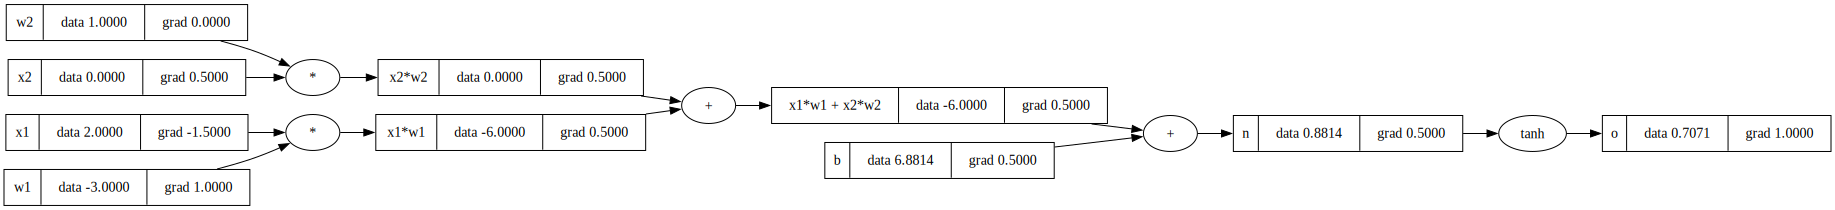

In [12]:
def lol8():
    # A 2 dimensional neuron with Input x1 and x2
    x1 = Value(2.0, _label='x1')
    x2 = Value(0.0, _label='x2')
    # The Weights
    w1 = Value(-3.0, _label='w1')
    w2 = Value(1.0, _label='w2')
    # The Bias
    b = Value(6.8813735870195432, _label='b')
    # The Flows
    x1w1 = x1 * w1; x1w1._label = 'x1*w1'
    x2w2 = x2 * w2; x2w2._label = 'x2*w2'
    x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1*w1 + x2*w2'
    # The Neuron
    n = x1w1x2w2 + b; n._label = 'n'
    # The Output
    o = n.tanh(); o._label = 'o'
    # 1. call backward to fill in all term's gradient
    o.backward()
    return o
    
draw_dot(lol8())

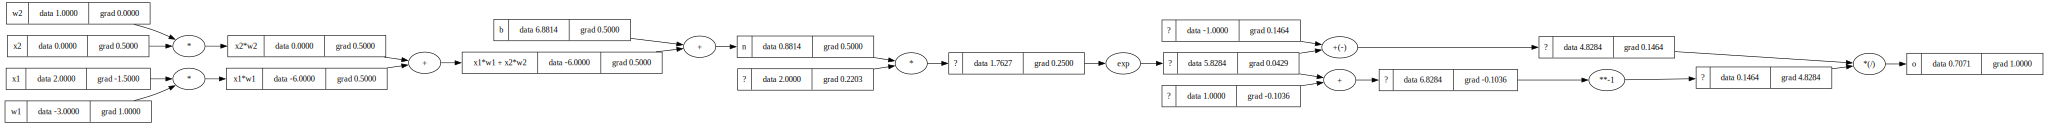

In [13]:
def lol9():
    # A 2 dimensional neuron with Input x1 and x2
    x1 = Value(2.0, _label='x1')
    x2 = Value(0.0, _label='x2')
    # The Weights
    w1 = Value(-3.0, _label='w1')
    w2 = Value(1.0, _label='w2')
    # The Bias
    b = Value(6.8813735870195432, _label='b')
    # The Flows
    x1w1 = x1 * w1; x1w1._label = 'x1*w1'
    x2w2 = x2 * w2; x2w2._label = 'x2*w2'
    x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1*w1 + x2*w2'
    # The Neuron
    n = x1w1x2w2 + b; n._label = 'n'
    # The Output, replace n.tanh() with Hyperbolic tangent formula
    e = (2 * n).exp()
    o = (e - 1) / (e + 1); o._label = 'o'
    # 1. call backward to fill in all term's gradient
    o.backward()
    return o
    
draw_dot(lol9())


# - 1 is redefined as + (neg(1)) with op '+(-)'
# division is redefined as self * other**-1
# tanh is redefined as (math.exp(2 * x) - 1)/(math.exp(2 * x) + 1) where x is n, hence
#   ((* (n, 2)) exp)
#   ((...), -1) +(-) 
#   ((...), 1) +
#   ...
# o.data is still expected to give 0.7071